In [2]:
import random
import matplotlib.pyplot as plt
import scipy as sc
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import warnings
warnings.filterwarnings('ignore')

InteractiveShell.ast_node_interactivity = "all"  # "last_expr"


%pylab inline
%matplotlib inline

np.random.seed(1)
np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.5f}'.format})

# %%writefile template.py#
# %load template.py - внешний файл
# %lsmagic

Populating the interactive namespace from numpy and matplotlib


In [3]:
from sklearn.metrics import pairwise_distances_argmin


def find_clusters(X, n_clusters):
    i = np.random.RandomState(2).permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        pred = pairwise_distances_argmin(X, centers, metric="manhattan")
        new_centers = np.array([X[pred == i].mean(0)
                                for i in range(n_clusters)])
        if np.all(centers == new_centers):
            break

        centers = new_centers
    return centers, pred

In [4]:
df = pd.read_csv('dataset.csv', header=0, sep=',')
df = df.rename(columns={'OD280%2FOD315_of_diluted_wines': "diluted_wines"})

Y = df['class']
X = df.drop(['class'], axis=1)

X -= X.quantile(.5)
X /= (X.quantile(.95) - X.quantile(.5))

X = X.values
Y = Y.values

from sklearn.preprocessing import LabelEncoder
Y = LabelEncoder().fit(Y).transform(Y)

In [5]:
print("classes:", df['class'].unique())
print("shape:", df.shape)
print("nulls:", df.isnull().values.any())

classes: [1 2 3]
shape: (178, 14)
nulls: False


In [6]:
from sklearn.decomposition import PCA
X_pca = PCA(n_components = 2).fit(X).transform(X)

In [8]:
centers, Y_pred = find_clusters(X, 3)

Text(0.5, 1.0, 'Real labels')

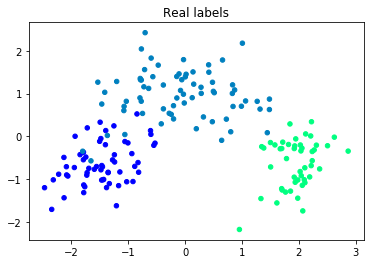

In [9]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = Y, s=20, cmap = 'winter')
plt.title("Real labels")

Text(0.5, 1.0, 'Predicted labels')

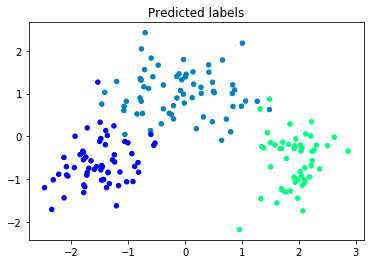

In [10]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = Y_pred, s=20, cmap = 'winter')
plt.title("Predicted labels")

# Внешняя метрика (Индекс Adjusted Rand)
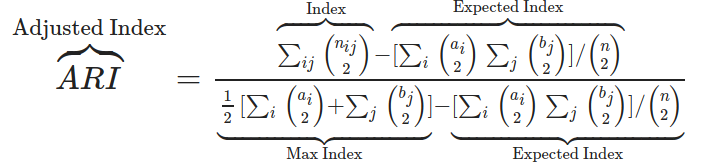

In [11]:
import math
from sklearn.metrics import confusion_matrix
from scipy.special import binom


def ari(pred, y):
    cm = confusion_matrix(pred, y)
    index = np.array([binom(x, 2)
                      for x in list(cm.reshape(len(cm)**2))]).sum()
    a_i = np.array([binom(x, 2)
                    for x in list(cm.sum(axis=0))]).sum()
    b_j = np.array([binom(x, 2)
                    for x in list(cm.sum(axis=1))]).sum()
    max_index = (a_i + b_j) / 2
    expected_index = a_i * b_j / binom(cm.sum(), 2)
    return (index - expected_index) / (max_index - expected_index)

In [12]:
print("Adjusted Rand:", ari(Y, Y_pred))

Adjusted Rand: 0.8471248932707481


# Внутренняя метрика (Отделимость кластеров)
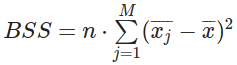

In [13]:
def bss(X, centers):
    x_mean = X.mean(0)
    return len(X) * np.sum((centers - x_mean) ** 2)

In [14]:
print("Cluster Separation:", bss(X, centers))

Cluster Separation: 1382.6509465528766


### Calinski–Harabasz

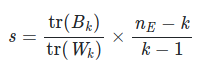

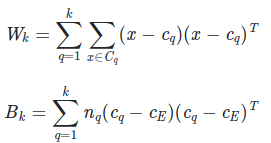

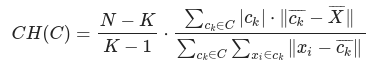

In [55]:
def ch(X, labels, centers):
    mean = np.mean(X, axis=0)
    B = np.sum([np.sum(labels == i)*(c - mean) **
                2 for i, c in enumerate(centers)])
    W = np.sum([(x-centers[labels[i]])**2 for i, x in enumerate(X)])
    k = len(centers)
    n = len(X)
    return ((n-k)*B)/1.0/((k-1)*W)

In [56]:
print("Calinski–Harabasz:", ch(X, Y_pred, centers))

Calinski–Harabasz: 82.8728169779918


# Зависимость от числа кластеров

Text(0.5, 1.0, 'ARI')

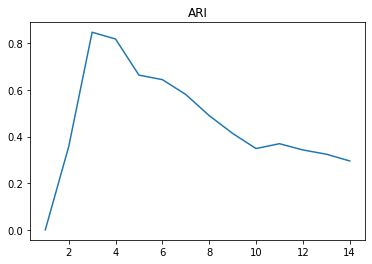

Text(0.5, 1.0, 'BSS')

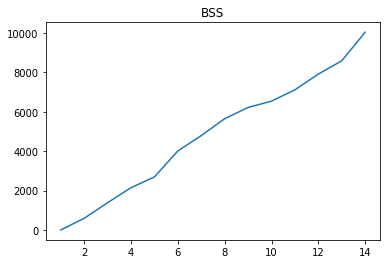

Text(0.5, 1.0, 'CH')

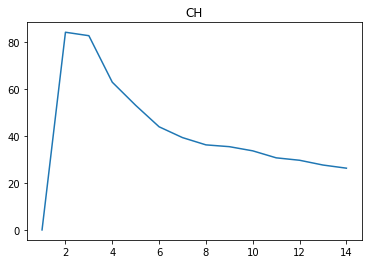

In [57]:
ari_s = []
bss_s = []
ch_s = []
n_clusters = range(1, 15)

for n in n_clusters:
    _centers, _Y_pred = find_clusters(X, n)
    ari_s.append(ari(Y, _Y_pred))
    bss_s.append(bss(X, _centers))
    ch_s.append(ch(X, _Y_pred,_centers))
    
plt.plot(n_clusters, ari_s)
plt.title("ARI")
plt.show()
plt.plot(n_clusters, bss_s)
plt.title("BSS")
plt.show()
ch_s[0]=0
plt.plot(n_clusters, ch_s)
plt.title("CH")
plt.show()